<a href="https://colab.research.google.com/github/johanjun/study_datascienceandpython/blob/main/oxford_pet(CAM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- ref : https://github.com/jwlee-ml/mobis2021

In [1]:
## library import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import re
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import xml.etree.ElementTree as et

In [2]:
print(tf.__version__)
print(keras.__version__)

2.5.0
2.5.0


# Data load

In [3]:
## google drive에서 압축된 dataset download
import gdown
url = 'https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0'
fname = 'oxford_pet.zip'
gdown.download(url, fname, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0
To: /content/oxford_pet.zip
811MB [00:05, 137MB/s] 


'oxford_pet.zip'

In [4]:
## 압축풀기
!unzip -q oxford_pet.zip -d oxford_pet

In [5]:
## directory 설정
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'oxford_pet')
image_dir = os.path.join(data_dir, 'images')

In [6]:
## image file 수 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg'] #확장자 분리
print(len(image_files))

7390


In [7]:
## image file들을 읽어서 channel이 3이 아닌 image는 삭제
for image_file in image_files:
  image_path = os.path.join(image_dir, image_file)
  image = Image.open(image_path)
  image_mode = image.mode
  if image_mode != 'RGB':
    print(image_file, image_mode)
    image = np.asarray(image)
    print(image.shape)
    os.remove(image_path)

Abyssinian_34.jpg P
(202, 250)
Egyptian_Mau_177.jpg P
(175, 246)
Abyssinian_5.jpg RGBA
(150, 200, 4)
staffordshire_bull_terrier_22.jpg L
(500, 364)
Egyptian_Mau_186.jpg RGBA
(275, 183, 4)
Egyptian_Mau_191.jpg P
(214, 300)
Egyptian_Mau_129.jpg L
(325, 299)
Egyptian_Mau_14.jpg RGBA
(800, 582, 4)
Egyptian_Mau_167.jpg P
(275, 183)
Egyptian_Mau_139.jpg P
(250, 350)
Egyptian_Mau_145.jpg P
(188, 216)
staffordshire_bull_terrier_2.jpg L
(282, 500)


In [8]:
## image file 수 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))

7378


In [9]:
# class 생성
class_list = set()
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\d+', '', file_name)
    class_list.add(class_name)
class_list = list(class_list)
print(len(class_list))

37


In [10]:
class_list.sort()
class_list

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [11]:
class2idx = {cls:idx for idx, cls in enumerate(class_list)}
class2idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [12]:
class2idx['Bengal']

1

In [13]:
## train, validation directory 생성
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [14]:
image_files.sort()
image_files[:10]

['Abyssinian_1.jpg',
 'Abyssinian_10.jpg',
 'Abyssinian_100.jpg',
 'Abyssinian_101.jpg',
 'Abyssinian_102.jpg',
 'Abyssinian_103.jpg',
 'Abyssinian_104.jpg',
 'Abyssinian_105.jpg',
 'Abyssinian_106.jpg',
 'Abyssinian_107.jpg']

In [15]:
cnt = 0
previous_class = ""
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\d+', '', file_name)
    if class_name == previous_class:
        cnt += 1
    else:
        cnt = 1
    if cnt <= 160:
        cpath = train_dir
    else:
        cpath = val_dir
    image_path = os.path.join(image_dir, image_file)
    shutil.copy(image_path, cpath)
    previous_class = class_name

In [16]:
train_images = os.listdir(train_dir)
val_images = os.listdir(val_dir)

print(len(train_images), len(val_images))

5920 1458


In [17]:
train_images[:10]

['Russian_Blue_28.jpg',
 'Ragdoll_18.jpg',
 'boxer_175.jpg',
 'saint_bernard_28.jpg',
 'staffordshire_bull_terrier_39.jpg',
 'boxer_36.jpg',
 'Bengal_179.jpg',
 'Birman_118.jpg',
 'scottish_terrier_153.jpg',
 'Abyssinian_138.jpg']

In [18]:
val_images[:10]

['german_shorthaired_9.jpg',
 'saint_bernard_97.jpg',
 'samoyed_84.jpg',
 'yorkshire_terrier_78.jpg',
 'havanese_82.jpg',
 'scottish_terrier_86.jpg',
 'saint_bernard_76.jpg',
 'newfoundland_65.jpg',
 'shiba_inu_80.jpg',
 'scottish_terrier_87.jpg']

# TFRecord File 만들기

In [19]:
IMG_SIZE = 224

In [20]:
## TFRecord 저장할 directory와 file 경로 설정
tfr_dir = os.path.join(data_dir, 'tfrecord')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'cls_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'cls_val.tfr')

In [21]:
## TFRecord writer 생성
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [22]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [23]:
## Training data로 tfrecord 만들기
n_train = 0

train_files = os.listdir(train_dir)
for train_file in train_files:
  train_path = os.path.join(train_dir, train_file)
  image = Image.open(train_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()

  file_name = os.path.splitext(train_file)[0] #Bangal_101
  class_name = re.sub('_\d+', '', file_name)
  class_num = class2idx[class_name]

  if file_name[0].islower(): # dog
    bi_cls_num = 0
  else: # cat
    bi_cls_num = 1

  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num),
      'bi_cls_num': _int64_feature(bi_cls_num)
  }))
  writer_train.write(example.SerializeToString())
  n_train += 1

writer_train.close()
print(n_train)

5920


In [24]:
## Validation data로 tfrecord 만들기
n_val = 0

val_files = os.listdir(val_dir)
for val_file in val_files:
  val_path = os.path.join(val_dir, val_file)
  image = Image.open(val_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()

  file_name = os.path.splitext(val_file)[0] #Bangal_101
  class_name = re.sub('_\d+', '', file_name)
  class_num = class2idx[class_name]

  if file_name[0].islower(): # dog
    bi_cls_num = 0
  else: # cat
    bi_cls_num = 1

  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num),
      'bi_cls_num': _int64_feature(bi_cls_num)
  }))
  writer_val.write(example.SerializeToString())
  n_val += 1

writer_val.close()
print(n_val)

1458


# classification

In [25]:
## Hyper Parameters
N_CLASS = len(class_list)
N_EPOCHS = 20
N_BATCH = 40
N_TRAIN = n_train
N_VAL = n_val
IMG_SIZE = 224
learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [26]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64),
              'bi_cls_num': tf.io.FixedLenFeature([], tf.int64)             
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255. 

    label = tf.cast(parsed_features['cls_num'], tf.int64)
    bi_cls_label = tf.cast(parsed_features['bi_cls_num'], tf.int64)

    return image, label

In [27]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(N_TRAIN).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [28]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH)

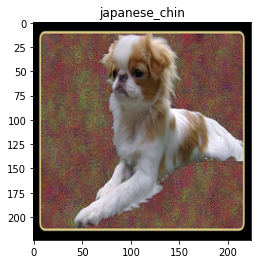

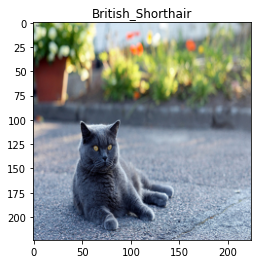

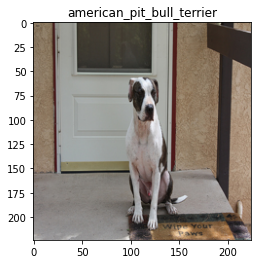

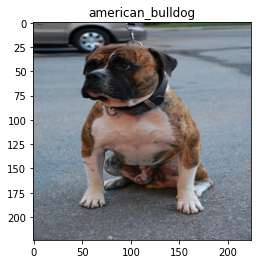

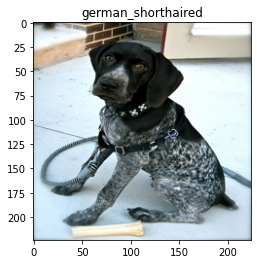

In [29]:
for image, label in train_dataset.take(5):
  plt.imshow(image[0])
  title = class_list[label[0].numpy()]
  plt.title(title)
  plt.show()

## modeling

In [30]:
from tensorflow.keras import models
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D

In [31]:
mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

9412608/9406464 [==============================] - 0s 0us/step


In [32]:
def create_mv_model():
  mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
  gap = GlobalAveragePooling2D()(mobilenetv2.output)
  output = Dense(N_CLASS, activation='softmax', name='output_layer')(gap)
  return keras.Model(inputs=mobilenetv2.input, outputs=output)

In [35]:
## Create model, compile & summary
model1 = create_mv_model()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*5,
                                                          decay_rate=0.5,
                                                          staircase=True)

model1.compile(keras.optimizers.Adam(lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [37]:
history = model1.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Epoch 1/20
148/148 [==============================] - 46s 159ms/step - loss: 1.1658 - accuracy: 0.7042 - val_loss: 0.5565 - val_accuracy: 0.8169
Epoch 2/20
148/148 [==============================] - 24s 153ms/step - loss: 0.2321 - accuracy: 0.9409 - val_loss: 0.4314 - val_accuracy: 0.8546
Epoch 3/20
148/148 [==============================] - 24s 154ms/step - loss: 0.0985 - accuracy: 0.9804 - val_loss: 0.3923 - val_accuracy: 0.8656
Epoch 4/20
148/148 [==============================] - 24s 154ms/step - loss: 0.0531 - accuracy: 0.9937 - val_loss: 0.3603 - val_accuracy: 0.8820
Epoch 5/20
148/148 [==============================] - 24s 154ms/step - loss: 0.0311 - accuracy: 0.9959 - val_loss: 0.3414 - val_accuracy: 0.8861
Epoch 6/20
148/148 [==============================] - 24s 154ms/step - loss: 0.0176 - accuracy: 0.9992 - val_loss: 0.2970 - val_accuracy: 0.8957
Epoch 7/20
148/148 [==============================] - 24s 153ms/step - loss: 0.0152 - accuracy: 0.9988 - val_loss: 0.2786 - val_ac

# Class Activation Map

In [40]:
target_fmap = model1.get_layer(name='out_relu').output
new_model1 = keras.models.Model(model1.input, target_fmap)

In [41]:
weights = model1.get_layer(name='output_layer').get_weights()[0]

In [42]:
weights.shape

(1280, 37)

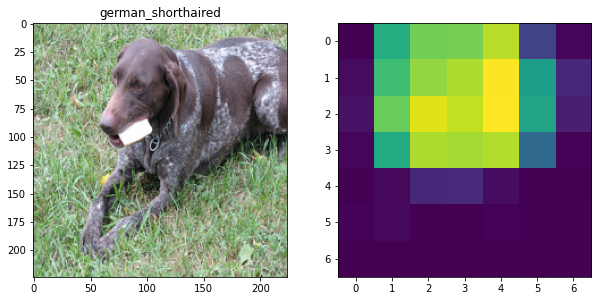

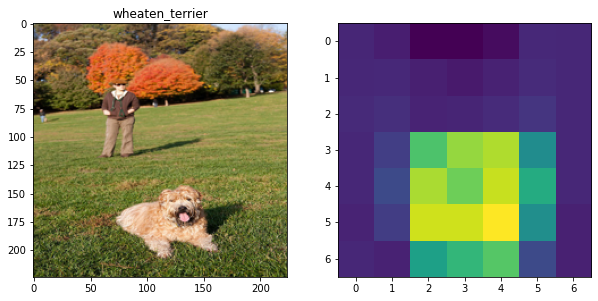

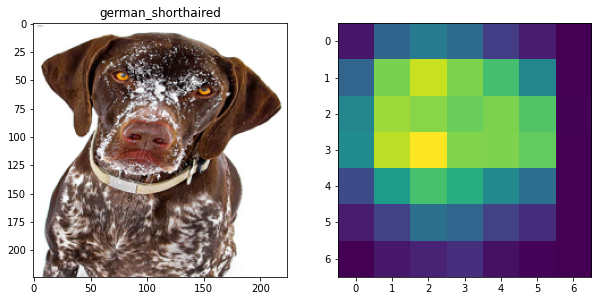

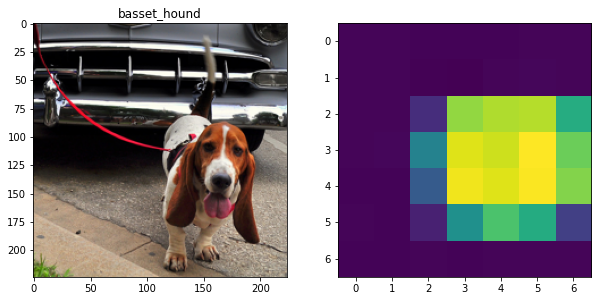

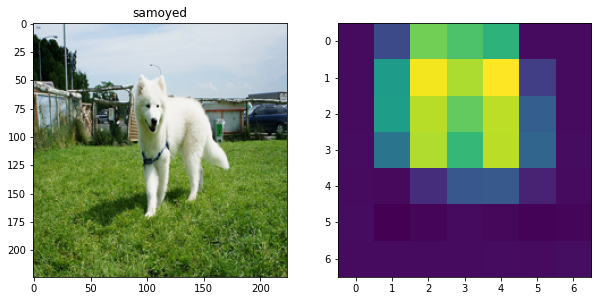

In [47]:
for images, labels in val_dataset.take(5):
  plt.figure(figsize=(10,6))

  plt.subplot(1,2,1)
  plt.imshow(images[0])
  prediction = model1.predict(images)
  pred_class = np.argmax(prediction[0], -1)
  title = class_list[pred_class]
  plt.title(title)

  plt.subplot(1,2,2)
  fmap = new_model1(images)
  weights_cam = weights[:, pred_class]
  camsum = np.zeros((7, 7))

  for i in range(1280):
    camsum += weights_cam[i]*fmap[0, :, :, i]
  camsum = camsum / 1280
  plt.imshow(camsum)

  plt.show()

In [48]:
N_CLASS = 2

In [49]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64),
              'bi_cls_num': tf.io.FixedLenFeature([], tf.int64)             
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255. 

    label = tf.cast(parsed_features['cls_num'], tf.int64)
    bi_cls_label = tf.cast(parsed_features['bi_cls_num'], tf.int64)

    return image, bi_cls_label

In [51]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(N_TRAIN).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [52]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH)

In [53]:
## Create model, compile & summary
model2 = create_mv_model()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*5,
                                                          decay_rate=0.5,
                                                          staircase=True)

model2.compile(keras.optimizers.Adam(lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [54]:
history = model2.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Epoch 1/20
148/148 [==============================] - 29s 158ms/step - loss: 0.0754 - accuracy: 0.9699 - val_loss: 0.0192 - val_accuracy: 0.9904
Epoch 2/20
148/148 [==============================] - 24s 152ms/step - loss: 0.0094 - accuracy: 0.9973 - val_loss: 0.0135 - val_accuracy: 0.9945
Epoch 3/20
148/148 [==============================] - 24s 154ms/step - loss: 0.0056 - accuracy: 0.9983 - val_loss: 0.0118 - val_accuracy: 0.9966
Epoch 4/20
148/148 [==============================] - 24s 153ms/step - loss: 0.0076 - accuracy: 0.9978 - val_loss: 0.0171 - val_accuracy: 0.9952
Epoch 5/20
148/148 [==============================] - 24s 153ms/step - loss: 0.0033 - accuracy: 0.9988 - val_loss: 0.0112 - val_accuracy: 0.9973
Epoch 6/20
148/148 [==============================] - 24s 153ms/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.0106 - val_accuracy: 0.9952
Epoch 7/20
148/148 [==============================] - 24s 152ms/step - loss: 0.0021 - accuracy: 0.9992 - val_loss: 0.0163 - val_ac

In [55]:
target_fmap = model2.get_layer(name='out_relu').output
new_model2 = keras.models.Model(model2.input, target_fmap)

In [57]:
weights = model2.get_layer(name='output_layer').get_weights()[0]

In [58]:
weights.shape

(1280, 2)

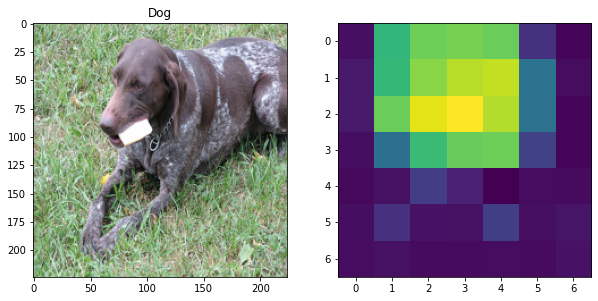

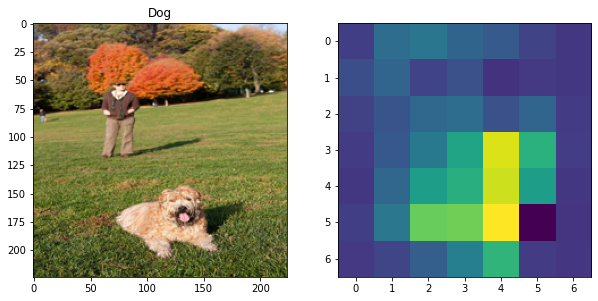

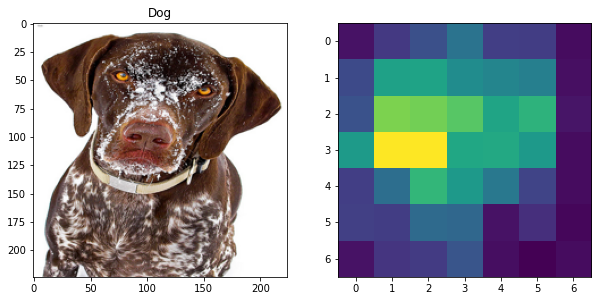

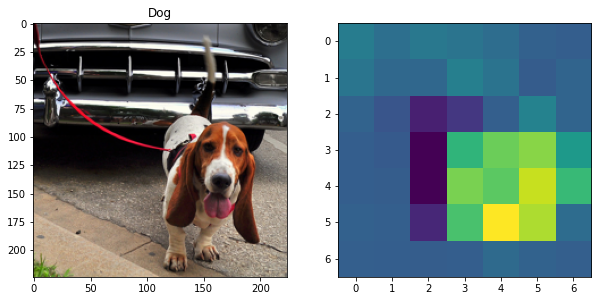

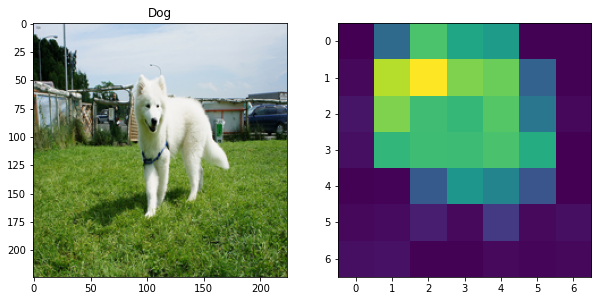

In [59]:
for images, labels in val_dataset.take(5):
  plt.figure(figsize=(10,6))

  plt.subplot(1,2,1)
  plt.imshow(images[0])
  prediction = model2.predict(images)
  pred_class = np.argmax(prediction[0], -1)
  if labels[0] == 0:
    title = 'Dog'
  else:
    title = 'Cat'


  plt.title(title)

  plt.subplot(1,2,2)
  fmap = new_model1(images)
  weights_cam = weights[:, pred_class]
  camsum = np.zeros((7, 7))

  for i in range(1280):
    camsum += weights_cam[i]*fmap[0, :, :, i]
  camsum = camsum / 1280
  
  plt.imshow(camsum)

  plt.show()

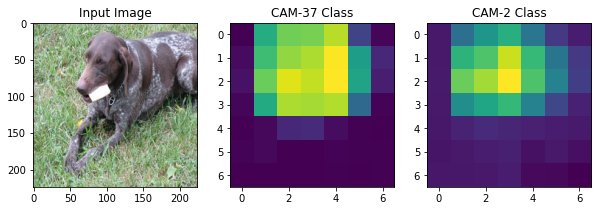

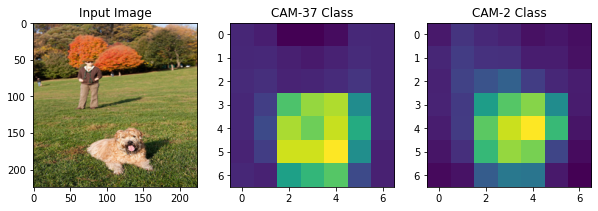

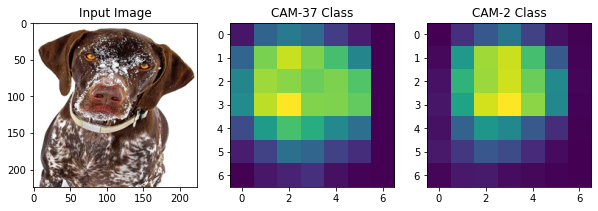

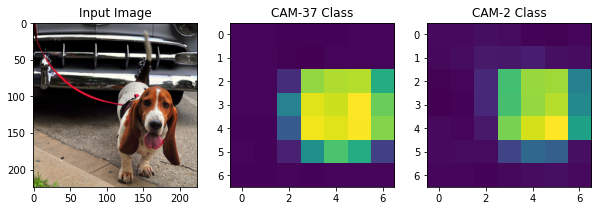

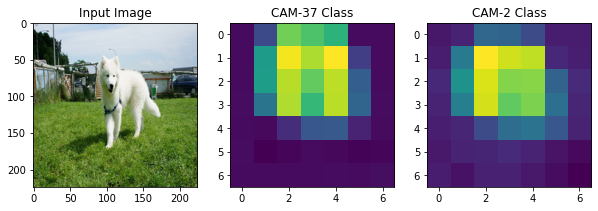

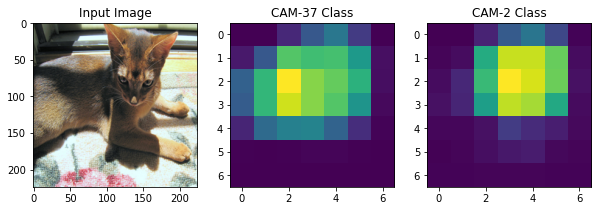

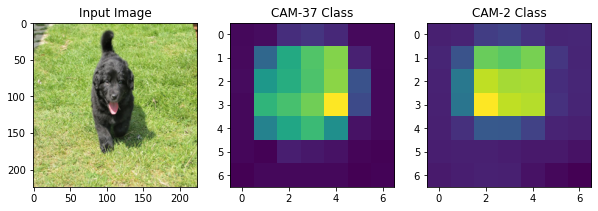

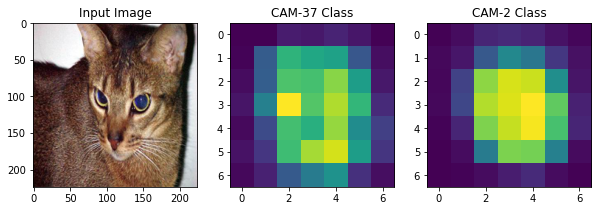

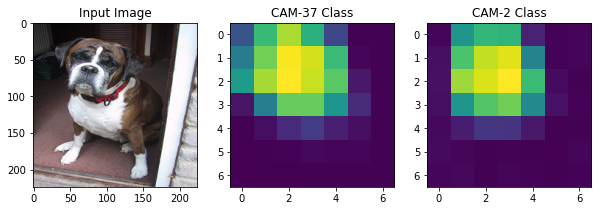

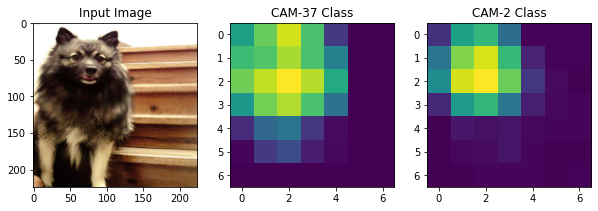

In [61]:
for images, labels in val_dataset.take(10):
  plt.figure(figsize=(10,6))

  plt.subplot(1,3,1)
  plt.imshow(images[0])
  plt.title('Input Image')


  plt.subplot(1,3,2)
  prediction1 = model1.predict(images)
  pred_class1 = np.argmax(prediction1[0], -1)
  fmap1 = new_model1(images)
  weights1 = model1.get_layer(name='output_layer').get_weights()[0]
  weights_cam1 = weights1[:, pred_class1]
  camsum1 = np.zeros((7, 7))

  for i in range(1280):
    camsum1 += weights_cam1[i]*fmap1[0,:,:,i]
  camsum1 = camsum1/1280
  plt.title('CAM-37 Class')
  plt.imshow(camsum1)


  plt.subplot(1,3,3)
  prediction2 = model2.predict(images)
  pred_class2 = np.argmax(prediction2[0], -1)
  fmap2 = new_model2(images)
  weights2 = model2.get_layer(name='output_layer').get_weights()[0]
  weights_cam2 = weights2[:, pred_class2]
  camsum2 = np.zeros((7, 7))

  for i in range(1280):
    camsum2 += weights_cam2[i]*fmap2[0,:,:,i]
  camsum2 = camsum2/1280
  plt.title('CAM-2 Class')
  plt.imshow(camsum2)


  

  plt.show()